In [1]:
import time
import os
import numpy as np
import torch
import torchvision.transforms as tv
import torchvision
from torchvision.utils import make_grid, save_image
from PIL import Image
from torchvision.transforms import Compose
import logging
import matplotlib.pyplot as plt
import pandas as pd
import glob
import copy
%matplotlib inline

In [2]:
'''Inference workflow 
 model = load_model(model_path) ->
 show_img_with_pred(image_path, model, show_results=1) | batch_prediction(images_folder_path, model, save_path=folder) '''

'Inference workflow \n model = load_model(model_path) ->\n show_img_with_pred(image_path, model, show_results=1) | batch_prediction(images_folder_path, model, save_path=folder) '

In [3]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("inference.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)
mylogs.info("Inference")

Inference


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")

Device is: cuda


In [5]:
def load_model(model_path):
    ''' Loads a model and its state dict. Accepts path to the model, returns the model. Default cnn type is resnet18 '''
    saved_model = torch.load(f'{model_path}')
    model_name  = saved_model['model_name']
    model_state_dict = saved_model['model_state_dict']
    size, n_channels, num_categories =  saved_model['parameters']
    parameters =  saved_model['parameters']
    mylogs.info("Model: " + model_name)
    #########
    from UNet import UNet
    model = UNet(n_channels, num_categories)
    model.load_state_dict(model_state_dict)
    return model, parameters

In [6]:
def image_loader(image_path, size,n_channels):
    '''loads image,transforms it and returns  tensor'''
    img = Image.open(image_path)
    img = img.resize((size[0], size[1]))
    img = transform(n_channels)(img)
    #As torch models expects a batch, this image should be turned into a batch with 1 image 
    img  = img.unsqueeze(0)
    return img.cpu() 

In [7]:
def apply_color_masks(image, mask):
    color_to_categories = ((0,0,100), (0,100,0), (100,0,0), (100,100,0), (100,0,100), 
                           (0,100,100), (100,100,100))
    
    image = image.squeeze()
    mask = mask.squeeze()
    
    image = np.stack((image,)*3, axis=-1)
    mask = np.stack((mask,)*3, axis=-1)
    
    masked_image = copy.deepcopy(image)
    
    # select category channel
    for category in np.unique(mask):
        if category:
            masked_image[:,:,0][mask[:,:,0]==category] = color_to_categories[category][0]
            masked_image[:,:,1][mask[:,:,0]==category] = color_to_categories[category][1]
            masked_image[:,:,2][mask[:,:,0]==category] = color_to_categories[category][2]
    return image, masked_image

In [8]:
def show_img_with_seg(image_path, model, size, num_categories , show_results=0):
    ''' Predicts one image, returns prediction '''
    image = image_loader(image_path, size, num_categories)
    image = image.to(device)
    model.to(device)
    with torch.no_grad():
        prediction_mask = model(image)
        prediction_mask = torch.argmax(prediction_mask, axis=1)
        masked_image = image
    if show_results:
        image = image.to('cpu')
        image = image.numpy()
        prediction_mask = prediction_mask.to('cpu')
        prediction_mask = prediction_mask.numpy()
        image, masked_image = apply_color_masks(image, prediction_mask)
        
        image = torch.from_numpy(image)
        masked_image = torch.from_numpy(masked_image)

        imgs = (image, masked_image)
        n_row = 1
        n_col = 2
        _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
        axs = axs.flatten()
        titles = [' Original Image', 'Image with mask', 'Mask']
        for title, img, ax in zip(titles, imgs, axs):
            ax.imshow(make_grid(img, 4))
            ax.set_title(title)
        plt.show()
    else:
        return masked_image, prediction_mask

In [9]:
def transform(n_channels):
    #Add normalisation and 8 bit converstion later
    return tv.Compose([
        tv.ToTensor(),
            tv.Normalize((0), (1))
        ])

In [10]:
model_path = "CT_multi_class_segmentation_Unet_inference.pt"
model, parameters = load_model(model_path)

Model: Unet


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


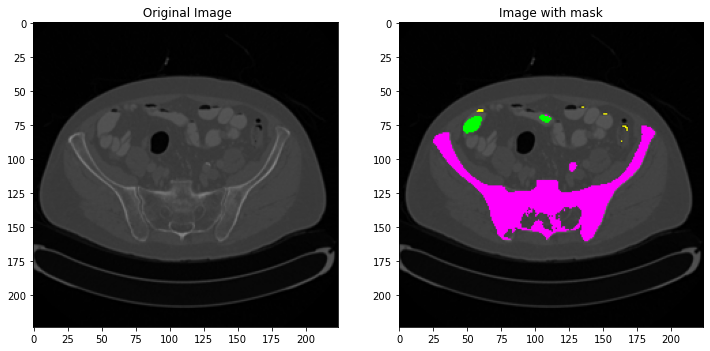

In [11]:
image_path = r'E:\ct_multi_segmentation\batch\volume-1270252.tif'
show_img_with_seg(image_path, model, parameters[0],  parameters[1], show_results=1)

In [12]:
image_path = r'E:\ct_multi_segmentation\batch\volume-1270252.tif'
image, mask = show_img_with_seg(image_path, model,  parameters[0],  parameters[1], show_results=0)

In [13]:
def save_masks(img, image_path,image_save_path,num_categories):
    # Saves image with torch and mask with np to preserve mask dimensions and type
        #### Change mask so it is saved correctly
    img = img.cpu()
    img = img.numpy()
    img = np.squeeze(img)
    img = (img*255)/num_categories
    img = Image.fromarray(img.astype(np.uint8))
    img.save(image_save_path + "\\" + os.path.basename(image_path).split('.')[0] + ".tiff")

In [14]:
def batch_prediction(images_folder_path,model,size, num_categories,mask_save_path, n_channels=1):
    ''' Make an inference on the images in the folder, returns a csv with results'''
    imgs_path_list = glob.glob(f'{images_folder_path}\*')
    mylogs.info(f"Inference started. \n {len(imgs_path_list)} images to segment")
    if not mask_save_path:
        mask_save_path = img_save_path     
    start_time = time.time()
    for image_path in imgs_path_list:
        seg_img, mask = show_img_with_seg(image_path, model,size, n_channels, show_results=None)
        save_masks(mask,image_path, mask_save_path, num_categories)
    end_time = time.time()
    total_time = int(end_time - start_time)
    mylogs.info(f'Inference finished. Elapsed time: {total_time }s')

In [15]:
images_folder_path = r'E:\ct_multi_segmentation\batch'
mask_save_path = r'E:\ct_multi_segmentation\results'
batch_prediction(images_folder_path, model, parameters[0],  parameters[2], mask_save_path)

Inference started. 
 987 images to segment
Inference finished. Elapsed time: 27s
